--- 1.1 Checking/Installing Libraries ---
--- 1.2 Loading Data: nigerian_stock_data.csv ---
Successfully loaded and cleaned 23,600 records.
Cleaned data saved to cleaned_nigerian_stock_data.csv for deployment.

--- 2.1 Preprocessing Data ---
Training Set Shape: (18832, 60, 5)
Testing Set Shape: (4708, 60, 5)

--- 4.1 Training LSTM Model ---
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


295/295 ━━━━━━━━━━━━━━━━━━━━ 66s 208ms/step - loss: 0.0299 - val_loss: 0.0025
Epoch 2/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 61s 207ms/step - loss: 0.0029 - val_loss: 0.0064
Epoch 3/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 60s 202ms/step - loss: 0.0019 - val_loss: 0.0072
Epoch 4/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 64s 218ms/step - loss: 0.0012 - val_loss: 0.0111
Epoch 5/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 62s 209ms/step - loss: 8.3046e-04 - val_loss: 0.0119
Epoch 6/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 63s 213ms/step - loss: 5.9565e-04 - val_loss: 0.0088

--- 4.2 Training GRU Model ---
Epoch 1/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 80s 253ms/step - loss: 0.0394 - val_loss: 0.0021
Epoch 2/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 71s 241ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 3/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 68s 230ms/step - loss: 0.0023 - val_loss: 0.0070
Epoch 4/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 82s 231ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 5/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 68s 231ms/step - loss: 0.0012 - val_loss:

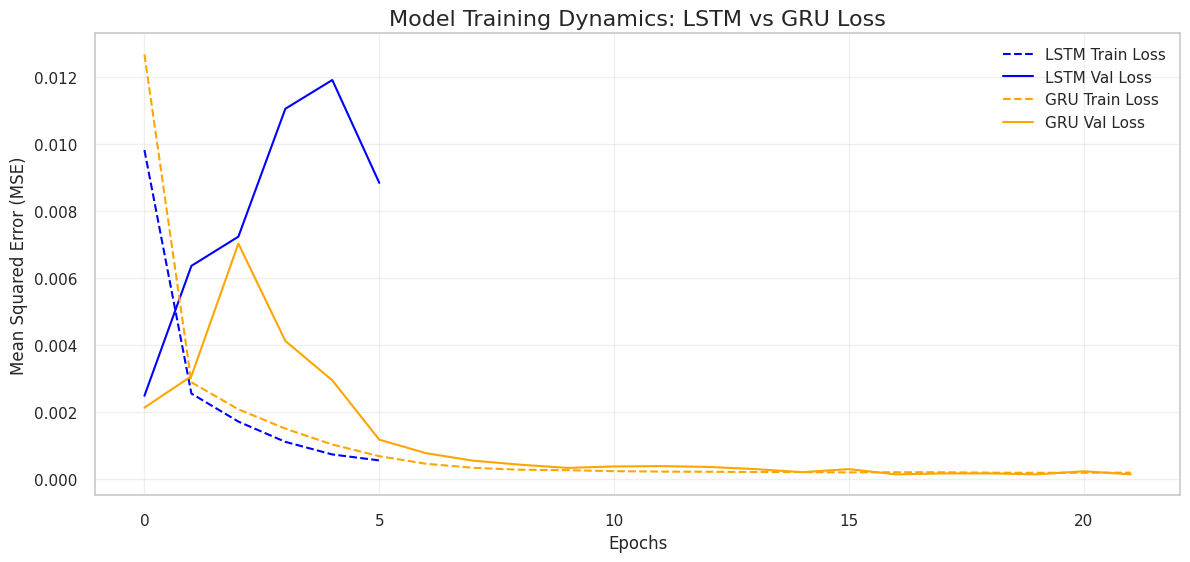


--- 5.2 Model Predictions vs Actuals (Test Set) ---
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step


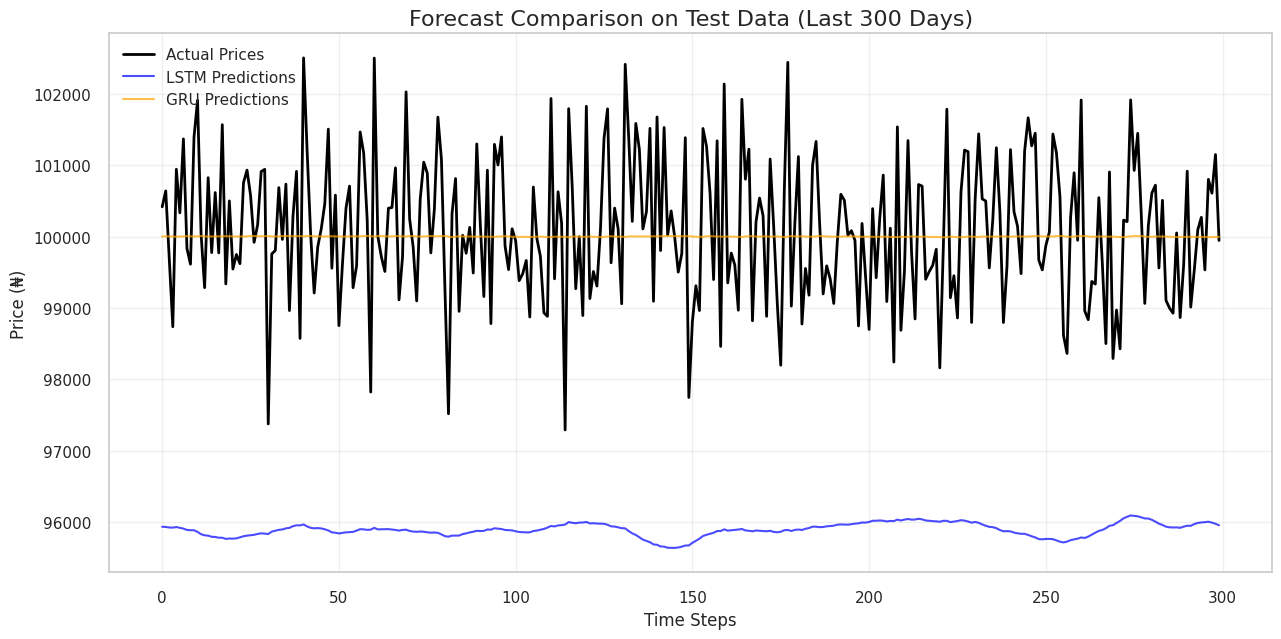


--- 5.3 Performance Metrics Comparison ---
  Model           MSE         RMSE          MAE
0  LSTM  1.795843e+07  4237.739281  4119.982867
1   GRU  9.796561e+05   989.775801   789.679482


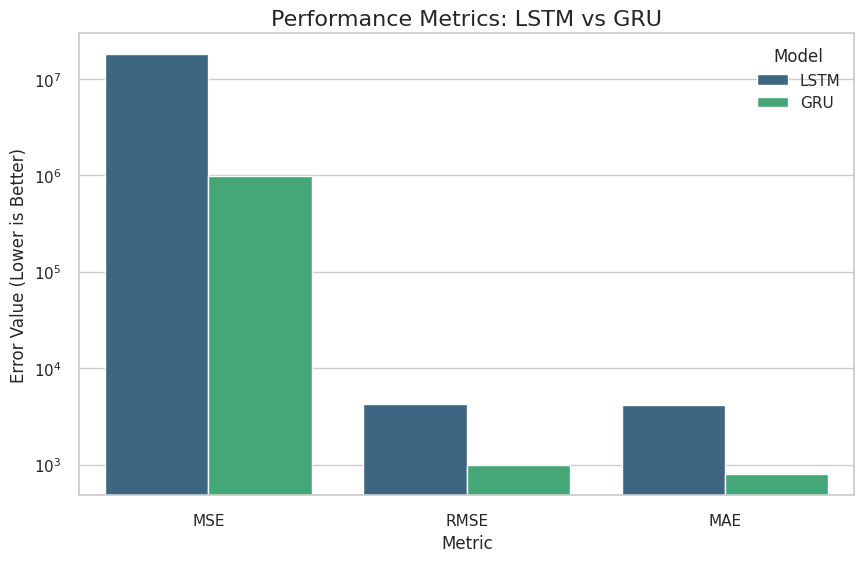


>>> WINNER: GRU Model performs better.
The best model has been saved as 'best_rnn_model.h5'.

--- DOWNLOAD THESE FILES FOR DEPLOYMENT ---
1. best_rnn_model.h5
2. cleaned_nigerian_stock_data.csv
3. app.py (Create this file locally using the provided code)


In [10]:
# -*- coding: utf-8 -*-
"""NSE Stock Price Prediction (LSTM vs GRU)
"""

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plot style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")

# --- 1. SETUP AND DATA LOADING ---

print("--- 1.1 Checking/Installing Libraries ---")
# !pip install pandas numpy tensorflow scikit-learn streamlit joblib matplotlib seaborn

# Configuration
INPUT_DATA_FILE = "nigerian_stock_data.csv" # Ensure this file is uploaded
APP_DATA_FILE = "cleaned_nigerian_stock_data.csv" # File to be saved for the app
LOOKBACK_PERIOD = 60
TRAINING_FEATURES = ['Price', 'Open', 'High', 'Low', 'Change %']
TEST_SPLIT = 0.2 # 20% for testing

# --- Data Loading ---
print(f"--- 1.2 Loading Data: {INPUT_DATA_FILE} ---")

if not os.path.exists(INPUT_DATA_FILE):
    print(f"\n[CRITICAL ERROR] The file '{INPUT_DATA_FILE}' was not found.")
    print("Please upload the CSV file to the Colab file system.")
    raise FileNotFoundError(f"{INPUT_DATA_FILE} not found.")

df_nse = pd.read_csv(INPUT_DATA_FILE)
df_nse['Date'] = pd.to_datetime(df_nse['Date'], dayfirst=True, errors='coerce')

# Clean and convert numerical columns
for col in ['Price', 'Open', 'High', 'Low']:
    if col in df_nse.columns:
        df_nse[col] = df_nse[col].astype(str).str.replace(',', '', regex=False)
        df_nse[col] = pd.to_numeric(df_nse[col], errors='coerce')

if 'Change %' in df_nse.columns:
    df_nse['Change %'] = df_nse['Change %'].astype(str).str.replace('%', '', regex=False)
    df_nse['Change %'] = pd.to_numeric(df_nse['Change %'], errors='coerce') / 100

# Fill any NaN values created by coercion
for col in TRAINING_FEATURES:
    if col in df_nse.columns:
        df_nse[col] = df_nse[col].fillna(df_nse[col].mean())

# Save cleaned data for the App
df_nse.to_csv(APP_DATA_FILE, index=False)
print(f"Successfully loaded and cleaned {len(df_nse):,} records.")
print(f"Cleaned data saved to {APP_DATA_FILE} for deployment.")

# --- 2. PREPROCESSING ---

print("\n--- 2.1 Preprocessing Data ---")
data_values = df_nse[TRAINING_FEATURES].values

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_values)

# Create Sequences
X = []
y = []

for i in range(LOOKBACK_PERIOD, len(scaled_data)):
    X.append(scaled_data[i-LOOKBACK_PERIOD:i])
    y.append(scaled_data[i, 0]) # Target: Price (index 0)

X = np.array(X)
y = np.array(y)

# 80/20 Split
split_idx = int(len(X) * (1 - TEST_SPLIT))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training Set Shape: {X_train.shape}")
print(f"Testing Set Shape: {X_test.shape}")

joblib.dump(scaler, 'scaler_all_data.joblib')


# --- 3. MODEL DEFINITIONS ---

def create_lstm_model(input_shape):
    """Creates a standard LSTM architecture."""
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(100, return_sequences=False),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dense(1)
    ], name="LSTM_Model")
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_gru_model(input_shape):
    """Creates a GRU architecture (Gated Recurrent Unit)."""
    model = Sequential([
        GRU(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        GRU(100, return_sequences=False),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dense(1)
    ], name="GRU_Model")
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# --- 4. TRAINING AND COMPARISON ---

input_shape = (LOOKBACK_PERIOD, len(TRAINING_FEATURES))
epochs = 30
batch_size = 64

# A. Train LSTM
print("\n--- 4.1 Training LSTM Model ---")
lstm_model = create_lstm_model(input_shape)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# B. Train GRU
print("\n--- 4.2 Training GRU Model ---")
gru_model = create_gru_model(input_shape)
# Re-use early stop to ensure fair comparison
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# --- 5. VISUALIZATION AND EVALUATION ---

print("\n--- 5.1 Training Loss Comparison ---")

plt.figure(figsize=(14, 6))
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss', color='blue', linestyle='--')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss', color='blue')
plt.plot(gru_history.history['loss'], label='GRU Train Loss', color='orange', linestyle='--')
plt.plot(gru_history.history['val_loss'], label='GRU Val Loss', color='orange')
plt.title('Model Training Dynamics: LSTM vs GRU Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n--- 5.2 Model Predictions vs Actuals (Test Set) ---")

# Generate Predictions
lstm_preds_scaled = lstm_model.predict(X_test)
gru_preds_scaled = gru_model.predict(X_test)

# Inverse Transform Helper
def inverse_transform_price(scaled_preds, scaler, n_features=5):
    dummy = np.zeros((len(scaled_preds), n_features))
    dummy[:, 0] = scaled_preds.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

lstm_preds = inverse_transform_price(lstm_preds_scaled, scaler)
gru_preds = inverse_transform_price(gru_preds_scaled, scaler)
actuals = inverse_transform_price(y_test.reshape(-1, 1), scaler)

# Plot Predictions (Subset for clarity if data is huge)
plot_len = 300 # Plot last 300 days for better visibility
plt.figure(figsize=(15, 7))
plt.plot(actuals[-plot_len:], label='Actual Prices', color='black', linewidth=2)
plt.plot(lstm_preds[-plot_len:], label='LSTM Predictions', color='blue', alpha=0.7)
plt.plot(gru_preds[-plot_len:], label='GRU Predictions', color='orange', alpha=0.7)
plt.title(f'Forecast Comparison on Test Data (Last {plot_len} Days)', fontsize=16)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Price (₦)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n--- 5.3 Performance Metrics Comparison ---")

# Calculate Metrics
metrics = {
    'Model': ['LSTM', 'GRU'],
    'MSE': [mean_squared_error(actuals, lstm_preds), mean_squared_error(actuals, gru_preds)],
    'RMSE': [np.sqrt(mean_squared_error(actuals, lstm_preds)), np.sqrt(mean_squared_error(actuals, gru_preds))],
    'MAE': [mean_absolute_error(actuals, lstm_preds), mean_absolute_error(actuals, gru_preds)]
}

df_metrics = pd.DataFrame(metrics)
print(df_metrics)

# Bar Chart for Metrics
df_melted = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Value")
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="Metric", y="Value", hue="Model", palette="viridis")
plt.title('Performance Metrics: LSTM vs GRU', fontsize=16)
plt.ylabel('Error Value (Lower is Better)', fontsize=12)
plt.yscale('log') # Log scale helps visualize MSE vs RMSE together
plt.show()

# Select Best Model
best_model_name = ""
if metrics['MSE'][0] < metrics['MSE'][1]:
    print("\n>>> WINNER: LSTM Model performs better.")
    lstm_model.save('best_rnn_model.h5')
    best_model_name = "LSTM"
else:
    print("\n>>> WINNER: GRU Model performs better.")
    gru_model.save('best_rnn_model.h5')
    best_model_name = "GRU"

print(f"The best model has been saved as 'best_rnn_model.h5'.")
print("\n--- DOWNLOAD THESE FILES FOR DEPLOYMENT ---")
print("1. best_rnn_model.h5")
print("2. cleaned_nigerian_stock_data.csv")
print("3. app.py (Create this file locally using the provided code)")